# 1. Background
Salt Lake County lies at the eastern boundary of the Basin and Range Province. The major active fault zone is the normal Wasatch Fault that throws down to the west. The footwall (upthrown part) is formed by the Wasatch Range with part of the Great Basin lying in the hanging-wall (downthrown part), at one time filled by Lake Bonneville, with the Great Salt Lake forming the largest remnant. The fault zone is broken up into six segments that appear to rupture separately. Paleoseismic investigations indicate that 19 surface rupturing earthquakes have occurred in the last 6,000 years along the fault system.

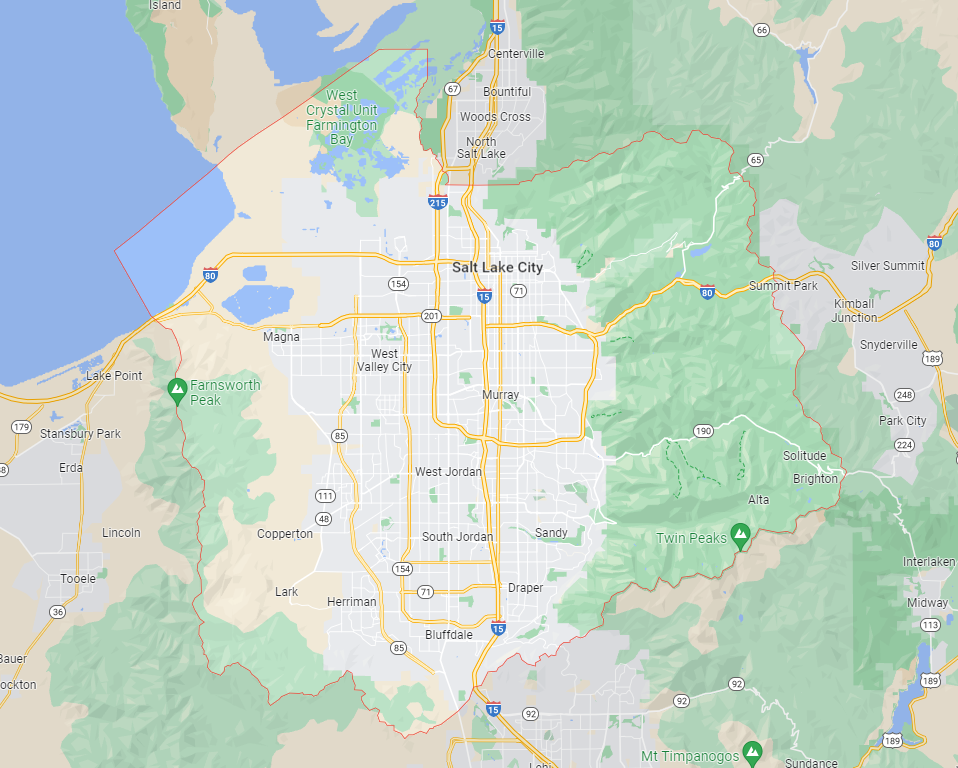

In this notebook, a model based Earthquake using Attenuation Models (Chiou and Youngs, 2014 NGA) is used for analyzing the damage for nearly 285,000 buildings, 670 bridges, 350 electric power substations and 15 electric power generation plants in the Salt Lake County while considering liquefaction. There are 34 building archetypes are considered in the analysis with the majority of buildings are RM1L (52342), RM2L (33116), URML (82047), and W1 (107704). Also, there are 11 bridge archetypes considered in the analysis with the majority of bridges are single span concrete (184) and multi-span continous steel bridges (123). The electric power substations are either low, medium or high voltage with the majority of them are low voltage substations. Similar to the electric power substations, the electric power generation plants are either small, medium or high power plants with the majority of them are small power plants.

# Prerequisites
The following modules are necessary to run this notebook. To ensure dependencies are correct, install all modules through conda.
     
     Module            Version          Notes
     
     pyIncore           =>1.8.0         see: https://incore.ncsa.illinois.edu/doc/incore/install_pyincore.html
     
     pyIncore_viz       =>1.8.2         see: https://incore.ncsa.illinois.edu/doc/pyincore_viz/index.html
     
     matplotlib         3.1.2           used for plotting results
     
- Building data: 62fea288f5438e1f8c515ef8
- Electric power substation data: 63daade962b9d001e6a16a0d
- Hazard data:   628fc3a2be7de109e898d718
- Building Mapping:       6309005ad76c6d0e1f6be081

In [ ]:
import pandas as pd
import os
import json
from pathlib import Path
import contextily as ctx
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import random

from pyincore import IncoreClient, DataService, HazardService, Dataset, FragilityService, MappingSet
from pyincore import HHRSOutputProcess

from pyincore.analyses.capitalshocks import CapitalShocks
from pyincore.analyses.buildingfunctionality import BuildingFunctionality
from pyincore.analyses.buildingdamage import BuildingDamage
from pyincore.analyses.epfdamage import EpfDamage
from pyincore.utils.dataprocessutil import DataProcessUtil
from pyincore.analyses.montecarlofailureprobability import MonteCarloFailureProbability 
from pyincore.analyses.saltlakecge import SaltLakeCGEModel
from pyincore.analyses.housingrecoverysequential import HousingRecoverySequential
from pyincore.analyses.socialvulnerability import SocialVulnerability
from pyincore.analyses.populationdislocation import PopulationDislocation, PopulationDislocationUtil
from pyincore.utils.dataprocessutil import DataProcessUtil as util

# 2. Building Damage Analysis

The following steps are applied for analysis
- 2.1 IN-CORE Client and Services
- 2.2 Import Building data
- 2.3 Specify Hazard and Fragility
- 2.4 Setup and Run Damage analysis
- 2.5 Plot Results
- 2.6 Monte Carlo Simulation (MCS)

## 2.1 IN-CORE Client and Services

In [ ]:
# Create IN-CORE client and connection to services
client = IncoreClient()
data_services = DataService(client)

## 2.2 Import Building data

In [ ]:
building_dataset_id = "62fea288f5438e1f8c515ef8" 
buildings = Dataset.from_data_service(building_dataset_id, data_services)

archetype_mapping = "63dbca62a011a9746c95697f"

## 2.3 Specify Hazard and Fragility

In [ ]:
# Hazard
hazard_type = "earthquake"
# hazard_id = "640a03ea73a1642180262450" # Mw 7.1 - Normal
# hazard_id = "640a03d0e1b6e54a477cb43b" # Mw 7.0 - Normal
# hazard_id = "640a03bcb7da86146357d63e" # Mw 6.9 - Normal
# hazard_id = "640a03a886a52d419dd69a33" # Mw 6.8 - Normal
# hazard_id = "6408d515e1b6e54a477cb434" # Mw 6.7 - Normal
# hazard_id = "6408dd57b7da86146357d638" # Mw 6.6 - Normal
# hazard_id = "6408dd8ae1b6e54a477cb435" # Mw 6.5 - Normal
# hazard_id = "6408e769b7da86146357d639" # Mw 6.4 - normal
# hazard_id = "6408e8c0e1b6e54a477cb436" # Mw 6.3 - Normal
hazard_id = "640622c873a1642180262449" # Mw 6.2 - Normal
# hazard_id = "6408ea13b7da86146357d63a" # Mw 6.1 - Normal
# hazard_id = "6408ea2de1b6e54a477cb437" # Mw 6.0 - Normal
# hazard_id = "6408ea4b73a164218026244d" # Mw 5.9 - Normal

liq_geology_dataset_id = "62fe9ab685ac6b569e372429"

# Fragility mapping
mapping_id = "6309005ad76c6d0e1f6be081" # Milad's mapping
fragility_service = FragilityService(client)
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))

In [ ]:
# Plot Liquefaction Susceptibility
#liq_dataset = Dataset.from_data_service(liq_geology_dataset_id, DataService(client))
#geoviz.plot_map(liq_dataset, column="liq_suscep", category=False, basemap=True)

## 2.4 Setup and Run Damage analysis 

In [ ]:
# Analysis setup
result_name = "SLC_bldg_dmg-withLIQ"

bldg_dmg = BuildingDamage(client)
bldg_dmg.set_input_dataset("buildings", buildings)
bldg_dmg.set_input_dataset('dfr3_mapping_set', mapping_set)
bldg_dmg.set_parameter("result_name", result_name)
bldg_dmg.set_parameter("hazard_type", hazard_type)
bldg_dmg.set_parameter("hazard_id", hazard_id)
bldg_dmg.set_parameter("use_liquefaction", True)
bldg_dmg.set_parameter("liquefaction_geology_dataset_id", liq_geology_dataset_id)
bldg_dmg.set_parameter("num_cpu", 8)

# Run building damage with liquefaction
bldg_dmg.run_analysis()

## 2.5 Plot analysis results

In [ ]:
# Print out 5 records from the analysis results
bldg_dmg.get_output_dataset('ds_result').get_dataframe_from_csv().head()

In [ ]:

# Adding information from inputs into analysis results
bldg_dmg_df = bldg_dmg.get_output_dataset("ds_result").get_dataframe_from_csv()
bldg_gdf = buildings.get_dataframe_from_shapefile()

arch_mapping_ds = Dataset.from_data_service(archetype_mapping, data_services)
arch_mapping = arch_mapping_ds.get_dataframe_from_csv()

print(arch_mapping)

max_dmg_state_df = DataProcessUtil.get_max_damage_state(bldg_dmg_df)
print(max_dmg_state_df)

ret_json = DataProcessUtil.create_mapped_dmg_result(bldg_gdf, max_dmg_state_df, arch_mapping, "max_state", "occ_type")
print(ret_json)

bldg_dmg_gdf = bldg_gdf[['guid', 'struct_typ','geometry']].merge(bldg_dmg_df, on='guid')
bldg_dmg_gdf.head()

In [ ]:
# Statistic summary for DS_3 state
# bldg_dmg_gdf["DS_3"].describe()

In [ ]:
# Histogram plot for DS_3
# ax = bldg_dmg_gdf['DS_3'].hist(bins=20, figsize=[10,5])
# ax.set_title("complete damage distribution", fontsize=12)
# ax.set_xlabel("complete damage value", fontsize=12)
# ax.set_ylabel("counts", fontsize=12)

In [ ]:
# Present analysis results om map
# geoviz.plot_gdf_map(bldg_dmg_gdf, 'DS_3', basemap=True)

## 2.6 Monte Carlo Simulation (MCS)

A Monte Carlo simulation (MCS) approach is employed to estimate the failure probability for each building in Salt Lake County. The MCS has been widely recognized as a powerful modeling tool in risk and reliability literature to solve mathematical problems using random samples, which allows capturing the uncertainty in the damage estimation process. The MCS begins with sampling a vector r from uniform distribution U(0,1), where the length of random vector r is the number of Monte Carlo samples given by N. The samples are compared with probabilities of all damage states corresponding to hazard intensity measures to determine the damage state of each component. Subsequently, the number of samples experiencing damage state 2 and higher is calculated and the failure probability is approximated

In [ ]:
#### Obtain the building damage results
building_dmg_result = bldg_dmg.get_output_dataset('ds_result')

#### Convert the building damage results to dataframe
df_bldg_dmg = building_dmg_result.get_dataframe_from_csv()

df_bldg_dmg.head()

In [ ]:
num_samples = 500 # Require 500 samples for convergence - Selected smaller samples for testing 
result_name = "SLC_mc_failure_probability_buildings_liquefaction"

mc_bldg = MonteCarloFailureProbability(client)

mc_bldg.set_input_dataset("damage", building_dmg_result)
mc_bldg.set_parameter("num_cpu", 8)
mc_bldg.set_parameter("num_samples", num_samples)
mc_bldg.set_parameter("damage_interval_keys", ["DS_0", "DS_1", "DS_2", "DS_3"])
mc_bldg.set_parameter("failure_state_keys", ["DS_1", "DS_2", "DS_3"])

mc_bldg.set_parameter("result_name", result_name) 

In [ ]:
mc_bldg.run_analysis() 

# Obtain buildings failure probabilities
building_failure_probability = mc_bldg.get_output_dataset('failure_probability')  

df_bldg_fail = building_failure_probability.get_dataframe_from_csv()
df_bldg_fail.head()

In [ ]:
# Obtain buildings sample damage states
sample_damage_states = mc_bldg.get_output_dataset('sample_damage_states')  
df_bldg_ds = sample_damage_states.get_dataframe_from_csv()
df_bldg_ds.head()

In [ ]:
building_damage_mcs_samples = mc_bldg.get_output_dataset('sample_failure_state')  # get buildings failure states

bdmcs = building_damage_mcs_samples.get_dataframe_from_csv()
bdmcs.head()

In [ ]:
# TODO: will include this in the next pyincore-viz release
# Code for creating the combined map 
# We create our own function by editing the existing code from pyincoreviz and add it to the pyincore viz class
# def my_plot_gdf_map(gdf, column, category=False, basemap=True, source=ctx.providers.OpenStreetMap.Mapnik,ax=None,legend = True, legend_kwds = None,cmap=None,marker="o"):
#     """Plot Geopandas DataFrame.
#     Args:
#         gdf (obj): Geopandas DataFrame object.
#         column (str): A column name to be plot.
#         category (bool): Turn on/off category option.
#         basemap (bool): Turn on/off base map (e.g. openstreetmap).
#         source(obj): source of the Map to be used. examples, ctx.providers.OpenStreetMap.Mapnik (default),
#             ctx.providers.Stamen.Terrain, ctx.providers.CartoDB.Positron etc.
#     """
#     if isinstance(ax, type(None)):
#         gdf = gdf.to_crs(epsg=3857)
#         ax = gdf.plot(figsize=(10, 10), column=column,
#                       categorical=category, legend=legend , legend_kwds = legend_kwds,cmap=cmap)
#         if basemap:
#             ctx.add_basemap(ax, source=source)
#     else:
#         gdf = gdf.to_crs(epsg=3857)
#         gdf.plot(ax=ax,column=column,
#               categorical=category, legend=legend , legend_kwds = legend_kwds,cmap=cmap,marker=marker)
#     return ax
# setattr(viz, "my_plot_gdf_map", my_plot_gdf_map)

# 4. Electric Power Facility (EPF) Damage Analysis

The following steps are applied for analysis
- 4.1 Import Electric Power Substation data
- 4.2 Specify Electric Power Substation Fragility and Mapping
- 4.3 Setup and Run Electric Power Substation Damage analysis
- 4.4 Plot Results for Electric Power Substation
- 4.5 Monte Carlo Simulation (MCS) of Electric Power Substation
- 4.6 Import Electric Power Generation Plants data
- 4.7 Specify Electric Power Generation Plants Fragility and Mapping
- 4.8 Setup and Run Electric Power Generation Plants Damage analysis
- 4.9 Plot Results for Electric Power Generation Plants
- 4.10 Monte Carlo Simulation (MCS) of Electric Power Generation Plants

## 4.1 Import Electric Power Substation data

In [ ]:
local_epf_ss = Dataset.from_data_service("63daade962b9d001e6a16a0d", data_services)

## 4.2 Specify Electric Power Substation Fragility and Mapping

In [ ]:
# Fragility mapping
mapping_id = "5b47be62337d4a37b6197a3a"

## 4.3 Setup and Run Electric Power Substation Damage analysis

In [ ]:
# Run epf damage 
eq_epf_ss_dmg = EpfDamage(client)
eq_epf_ss_dmg.set_input_dataset("epfs", local_epf_ss)

# Load fragility mapping
fragility_service = FragilityService(client)
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))
eq_epf_ss_dmg.set_input_dataset("dfr3_mapping_set", mapping_set)

In [ ]:
result_name = "hazus_epf_ss_dmg_result"
eq_epf_ss_dmg.set_parameter("result_name", result_name)
eq_epf_ss_dmg.set_parameter("hazard_type", hazard_type)
eq_epf_ss_dmg.set_parameter("hazard_id", hazard_id)
eq_epf_ss_dmg.set_parameter("use_liquefaction", True)
eq_epf_ss_dmg.set_parameter("liquefaction_geology_dataset_id", liq_geology_dataset_id)
eq_epf_ss_dmg.set_parameter("num_cpu", 8)

# Run Analysis
eq_epf_ss_dmg.run_analysis()

## 4.4 Plot Results for Electric Power Substation

In [ ]:
epf_ss_dmg_df=eq_epf_ss_dmg.get_output_dataset('result').get_dataframe_from_csv()
epf_ss_dmg_df.head()

In [ ]:
DSlist = np.array(['DS_0', 'DS_1', 'DS_2', 'DS_3', 'DS_4'])
spf_ss_likelyDS = DSlist[epf_ss_dmg_df.loc[:,['DS_0', 'DS_1', 'DS_2', 'DS_3','DS_4']].values.argmax(axis=1)]
epf_ss_dmg_df['likelyDS'] = spf_ss_likelyDS
keys, counts = np.unique(spf_ss_likelyDS, return_counts=True)

fig, ax = plt.subplots()
ax.bar(keys, counts)
ax.set_title("Damage State Distribution", fontsize=12)
ax.set_xlabel("Likely Damage State", fontsize=12)
ax.set_ylabel("Counts", fontsize=12)

In [ ]:
#Plotting the most likely damage state for bridges
# epf_ss_gdf = local_epf_ss.get_dataframe_from_shapefile()
# joined_epf_ss_gdf = epf_ss_gdf.set_index("guid").join(epf_ss_dmg_df.set_index("guid"))
# ax = viz.my_plot_gdf_map(joined_epf_ss_gdf,column='likelyDS',category = True,basemap=True,cmap='YlOrRd')
# orddict={'DS_0': 'No Damage','DS_1': 'Insignificant', 'DS_2': 'Moderate', 'DS_3': 'Heavy', 'DS_4': 'Complete'}
# def replace_legend_items(legend, mapping):
#     for txt in legend.texts:
#         for k,v in mapping.items():
#             if txt.get_text() == str(k):
#                 txt.set_text(v)
# replace_legend_items(ax.get_legend(), orddict)

In [ ]:
# Adding information from inputs into analysis results
epf_ss_gdf = local_epf_ss.get_dataframe_from_shapefile()
epf_ss_dmg_df = epf_ss_gdf[['guid', 'utilfcltyc','geometry']].merge(epf_ss_dmg_df, on='guid')
epf_ss_dmg_df.head()

In [ ]:
# Statistic summary for DS_4 state
epf_ss_dmg_df["DS_4"].describe()

In [ ]:
# Histogram plot for DS_4
ax = epf_ss_dmg_df['DS_4'].hist(bins=20, figsize=[10,5])
ax.set_title("complete damage distribution", fontsize=12)
ax.set_xlabel("complete damage value", fontsize=12)
ax.set_ylabel("counts", fontsize=12)

## 4.5 Monte Carlo Simulation (MCS) of Electric Power Substation

In [ ]:
num_samples = 500
mc_sub = MonteCarloFailureProbability(client)

result_name = "SLC_EPN_substations_mc_failure_probability"
substation_dmg_result=eq_epf_ss_dmg.get_output_dataset('result')

mc_sub.set_input_dataset("damage", substation_dmg_result)
mc_sub.set_parameter("num_cpu", 8)
mc_sub.set_parameter("num_samples", num_samples)
mc_sub.set_parameter("damage_interval_keys", ["DS_0", "DS_1", "DS_2", "DS_3", "DS_4"])
mc_sub.set_parameter("failure_state_keys", ["DS_1", "DS_2", "DS_3", "DS_4"])

mc_sub.set_parameter("result_name", result_name) # name of csv file with results
mc_sub.run_analysis()

In [ ]:
substation_failure_probability = mc_sub.get_output_dataset('failure_probability')  # get buildings failure probabilities

df_substation_fail = substation_failure_probability.get_dataframe_from_csv()
df_substation_fail.head()

In [ ]:
substation_damage_mcs_samples = mc_sub.get_output_dataset('sample_failure_state')

sdmcs = substation_damage_mcs_samples.get_dataframe_from_csv()
sdmcs.head()

# 5. Physical Funcationality Analysis

# 5.1. Functionality of Buildings and Substations

The MC samples from earlier subsection are used in this subsection to perform functionality analysis and determine the functionality state of each building. According to Almufti and Willford (2013), functionality is defined as the capacity of a component to serve its intended objectives consist of structural integrity, safety, and utilities (e.g., water and electricity). An individual building can be narrowly classified into five discrete states consist of the restricted entry (State 1), restricted use (State 2), preoccupancy (State 3), baseline functionality (State 4) and full functionality (State 5). In a broader classification, functionality states can be categorized into nonfunctional (States 1 to 3) and functional (States 4 and 5). This notebook relies on the latter broader classification approach to estimate the functionality state of each building and subsequently use functionality estimates to perfom functionality analysis by accounting for interdependency between buildings and lifeline networks (i.e., EPN) 

In [ ]:
depend_dict_id = "63daae5366818b21b82a07a4"

bldg_func = BuildingFunctionality(client)

# Load the datasets of MC simulations for buildings
bldg_func.set_input_dataset("building_damage_mcs_samples", building_damage_mcs_samples)
bldg_func.set_input_dataset("substations_damage_mcs_samples", substation_damage_mcs_samples)
bldg_func.load_remote_input_dataset("interdependency_dictionary", depend_dict_id)

result_name = "SLC_mcs_functionality_probability_liquefaction"
bldg_func.set_parameter("result_name", result_name)

In [ ]:
### Run the BuildingFunctionality module to obtain the building functionality probabilities
bldg_func.run_analysis() 

bldg_func_samples = bldg_func.get_output_dataset('functionality_samples')
df_bldg_samples = bldg_func_samples.get_dataframe_from_csv()
df_bldg_samples.head()

In [ ]:
bldg_func_probability = bldg_func.get_output_dataset('functionality_probability')
df_bldg_func = bldg_func_probability.get_dataframe_from_csv()
df_bldg_func = df_bldg_func.rename(columns={"building_guid": "guid"})
func_prob_target = 0.40
df_bldg_func.loc[df_bldg_func['probability'] <= func_prob_target, 'functionality'] = 0 # Non-Functional
df_bldg_func.loc[df_bldg_func['probability'] > func_prob_target, 'functionality'] = 1 # Functional
df_bldg_func.loc[df_bldg_func['probability'] <= func_prob_target, 'functionality_state'] = 'Non-Functional' # Non-Functional
df_bldg_func.loc[df_bldg_func['probability'] > func_prob_target, 'functionality_state'] = 'Functional' # Functional

In [ ]:
df_bldg_func.head()

In [ ]:
### Plot of the distribution of functionality state for buildings
indexes = df_bldg_func['functionality_state'].value_counts(normalize=True).mul(100).index.tolist()
values = df_bldg_func['functionality_state'].value_counts(normalize=True).mul(100).tolist()

fig, ax = plt.subplots(figsize=(4, 2.5), dpi=200)

bars = ax.bar(x=indexes, height=values,)

for bar in bars:
    ax.text(bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 3,f'% {bar.get_height() :.1f}',
            horizontalalignment='center')

fig.tight_layout()
ax.set_ylim([0,100])
ax.set_xlabel('Damage State', labelpad=15)
ax.set_ylabel('Percentage', labelpad=15)
ax.set_title('Functionality Percentage (Buildings and Substations)', pad=15)
ax.set(frame_on=False);

# 6. Sociological Analysis


This section introduces the sociology-based analysis which may be integrated with hazard and building damage analysis. In this example the damage to buildings drives the population dislocation algorithm at the household level.

# 6.1. Population Dislocation Model

Population dislocation refers to households that will be forced to leave their pre-event residence due to hazard related damages. Population dislocation is a function of structure value loss due to damage, neighborhood characteristics and structure type.

The population dislocation model depends first on the allocation of detailed housing unit and household characteristic data to each residential building within the community. The allocation of detailed household characteristic data provides an estimate of the number of people that live within each structure.

The model predicts which households within the community will be dislocated from their homes immediately following the hazard event.

## Use new pyincore-data utility to obtain Block Group Data for County

In [ ]:
# from pyincore_data.censusutil import CensusUtil

In [ ]:
# state_counties = ['49035']
# blockgroup_df, bgmap = CensusUtil.get_blockgroupdata_for_dislocation(state_counties, 
#                                                                  out_csv=True, 
#                                                                  out_shapefile=False, 
#                                                                  out_html=False)

In [ ]:
# blockgroup_df.head()

In [ ]:
# Salt Lake County, UT Block group data, TODO - upload this to data service
# bg_data = Dataset.from_file('program_name/program_name_geo_name.csv','incore:blockGroupData')
bg_data = "63c9af5bc4b5713b9c0b559d"

In [ ]:
housing_unit_alloc = "6349cfb888a94f621d8fd5dd"
value_loss = "60354810e379f22e16560dbd"

In [ ]:
# Create Population dislocation analysis
pop_dis = PopulationDislocation(client)

In [ ]:
# Load analysis input datasets
pop_dis.load_remote_input_dataset("housing_unit_allocation", housing_unit_alloc)
pop_dis.load_remote_input_dataset("block_group_data", bg_data)
pop_dis.load_remote_input_dataset("value_loss_param", value_loss)
building_dmg_result = bldg_dmg.get_output_dataset('ds_result')
pop_dis.set_input_dataset("building_dmg", building_dmg_result)

In [ ]:
result_name = "pop-dislocation-results"
seed = 1111

pop_dis.set_parameter("result_name", result_name)
pop_dis.set_parameter("seed", seed)

In [ ]:
pop_dis.run_analysis()

# Retrieve result dataset
result = pop_dis.get_output_dataset("result")

# Convert dataset to Pandas DataFrame
df = result.get_dataframe_from_csv(low_memory=False)
df.head()

# 7.2. Sociological Resilience Metrics

## 7.2.1. Percent of Population Dislocation

To determine if a household dislocate a random value was uniformly sampled between 0 and 1: if this value was lower than the probability of dislocation, then the household was set to dislocate. The results below provide one example of how the output can be explored by population subgroups. The model is designed to run as part of a larger Monte Carlo Simulation.

In [ ]:
pop_result = pop_dis.get_output_dataset("result")

df = pop_result.get_dataframe_from_csv(low_memory=False)
# Select Housing units allocated to buildings

In [ ]:
table_title = "Total population by tenure status and dislocation."
pd.crosstab(df['ownershp'], df['dislocated'], df['numprec'], aggfunc = sum,
            dropna=True, margins=True, margins_name="Total").style.set_caption(table_title)

The variable ownershp represents the tenure status of households. When ownershp = 1 the housing unit is owner-occupied. When the ownershp = 2 the housing unit is renter-occupied. The results above provide the percent of the population predicted to dislocate based on tenure status. When the variable dislocated = True the household is predicted to dislocate.

# Capital Stock Shock and CGE Analysis

In [ ]:
# Salt Lake building to sector mapping table
building_to_sectors_id = "63ffd2c6a36332563d49a88d"

In [ ]:
# Create Capital shocks analysis
capital_shocks = CapitalShocks(client)

# Load remote datasets
capital_shocks.load_remote_input_dataset("buildings_to_sectors", building_to_sectors_id)
# Set datasets
# Salt Lake building inventory
capital_shocks.load_remote_input_dataset("buildings", building_dataset_id)
# Salt Lake building failure probability
capital_shocks.set_input_dataset("failure_probability", building_failure_probability)

capital_shocks.set_parameter("result_name", "sector_shocks") # name of csv file with results

In [ ]:
# Run capital shocks analysis
capital_shocks.run_analysis()

sector_shocks_result = capital_shocks.get_output_dataset("sector_shocks")
sector_shocks_result.get_dataframe_from_csv()

In [ ]:
# Create Salt Lake CGE Model - TODO replace this with production client later
saltlake_cge = SaltLakeCGEModel(client)

In [ ]:
# Set CGE Inputs
saltlake_cge.set_parameter("model_iterations", 1)
saltlake_cge.load_remote_input_dataset("SAM", "6408c4a8475d895dfc2e5f05")
saltlake_cge.load_remote_input_dataset("BB", "6408c3ffc4841b26d143e77f")
saltlake_cge.load_remote_input_dataset("MISCH", "6408c50718fd3853fb31d713")
saltlake_cge.load_remote_input_dataset("EMPLOY", "6408c56cba377224eb7caa9a")
saltlake_cge.load_remote_input_dataset("JOBCR", "6408c5c7c4841b26d143e786")
saltlake_cge.load_remote_input_dataset("OUTCR", "6408c61d475d895dfc2e5f0d")
saltlake_cge.set_input_dataset("sector_shocks", sector_shocks_result)

In [ ]:
# Run CGE
saltlake_cge.run_analysis()

In [ ]:
# Display Output for domestic supply
result = saltlake_cge.get_output_dataset("domestic-supply")
df = result.get_dataframe_from_csv()

# Display top 5 rows of output data
df.head()

In [ ]:
# Parameters - State and County
# state = "Utah"
# county = "Salt Lake"
# year = 2020

In [ ]:
# get fips code to use fetch census data
# fips = CensusUtil.get_fips_by_state_county(state=state, county=county)
# state_code = fips[:2]
# county_code = fips[2:]
# fips

In [ ]:
# def demographic_factors(state_number, county_number, year, geo_type="tract:*"):

#     _, df_1 = CensusUtil.get_census_data(state=state_code, county=county_code, year=year,
#                                                               data_source="acs/acs5",
#                                                               columns="GEO_ID,B03002_001E,B03002_003E",
#                                                               geo_type=geo_type)
#     df_1["factor_white_nonHispanic"] = df_1[["B03002_001E","B03002_003E"]].astype(int).apply(lambda row: row["B03002_003E"]/row["B03002_001E"], axis = 1)

#     _, df_2 = CensusUtil.get_census_data(state=state_code, county=county_code, year=year,
#                                                   data_source="acs/acs5",
#                                                   columns="B25003_001E,B25003_002E",
#                                                   geo_type=geo_type)
#     df_2["factor_owner_occupied"] = df_2.astype(int).apply(lambda row: row["B25003_002E"]/row["B25003_001E"], axis = 1)
    
#     _, df_3 = CensusUtil.get_census_data(state=state_code, 
#                                          county=county_code, 
#                                          year=year,
#                                          data_source="acs/acs5",
#                                          columns="B17021_001E,B17021_002E",
#                                          geo_type=geo_type)
#     df_3["factor_earning_higher_than_national_poverty_rate"] = df_3.astype(int).apply(lambda row: 1-row["B17021_002E"]/row["B17021_001E"], axis = 1)
    
#     _, df_4 = CensusUtil.get_census_data(state=state_code, 
#                                          county=county_code, 
#                                          year=year,
#                                          data_source="acs/acs5", 
#                                          columns="B15003_001E,B15003_017E,B15003_018E,B15003_019E,B15003_020E,B15003_021E,B15003_022E,B15003_023E,B15003_024E,B15003_025E",
#                                          geo_type=geo_type)
#     df_4["factor_over_25_with_high_school_diploma_or_higher"] = df_4.astype(int).apply(lambda row: (row["B15003_017E"] 
#                                                                                                     + row["B15003_018E"] 
#                                                                                                     + row["B15003_019E"] 
#                                                                                                     + row["B15003_020E"] 
#                                                                                                     + row["B15003_021E"] 
#                                                                                                     + row["B15003_022E"] 
#                                                                                                     + row["B15003_023E"] 
#                                                                                                     + row["B15003_024E"] 
#                                                                                                     + row["B15003_025E"])/row["B15003_001E"], axis = 1)

#     if geo_type == 'tract:*':
#         _, df_5 = CensusUtil.get_census_data(state=state_code, 
#                                              county=county_code, 
#                                              year=year,
#                                              data_source="acs/acs5",
#                                              columns="B18101_001E,B18101_011E,B18101_014E,B18101_030E,B18101_033E",
#                                              geo_type=geo_type)
#         df_5["factor_without_disability_age_18_to_65"] = df_5.astype(int).apply(lambda row: (row["B18101_011E"] + row["B18101_014E"] + row["B18101_030E"] + row["B18101_033E"])/row["B18101_001E"], axis = 1)
    
#     elif geo_type == 'block%20group:*':
#         _, df_5 = CensusUtil.get_census_data(state=state_code, 
#                                              county=county_code, 
#                                              year=year,
#                                              data_source="acs/acs5",
#                                              columns="B01003_001E,C21007_006E,C21007_009E,C21007_013E,C21007_016E",
#                                              geo_type=geo_type)

#         df_5['factor_without_disability_age_18_to_65'] = df_5.astype(int).apply(lambda row: (row['C21007_006E']+
#                                                                                  row['C21007_006E']+
#                                                                                  row['C21007_009E']+
#                                                                                  row['C21007_013E'])
#                                                                                 /row['C21007_016E'], axis = 1)

#     df_t = pd.concat([df_1[["GEO_ID","factor_white_nonHispanic"]],
#                       df_2["factor_owner_occupied"],
#                       df_3["factor_earning_higher_than_national_poverty_rate"], 
#                       df_4["factor_over_25_with_high_school_diploma_or_higher"],
#                       df_5["factor_without_disability_age_18_to_65"]], 
#                      axis=1, join='inner')
    
#     # extract FIPS from geo id
#     df_t["FIPS"] = df_t.apply(lambda row: row["GEO_ID"].split("US")[1], axis = 1)
        
#     return df_t

In [ ]:
# def national_ave_values(year, data_source="acs/acs5"):
#     _, nav1 = CensusUtil.get_census_data(state="*", county=None, year=year, data_source=data_source,
#                              columns="B03002_001E,B03002_003E",geo_type=None)
#     nav1 = nav1.astype(int)
#     nav1_avg ={"feature": "NAV-1: White, nonHispanic", 
#                 "average": nav1['B03002_003E'].sum()/ nav1['B03002_001E'].sum()}

#     _, nav2 = CensusUtil.get_census_data(state="*", county=None, year=year, data_source=data_source,
#                              columns="B25003_001E,B25003_002E",geo_type=None)
#     nav2 = nav2.astype(int)
#     nav2_avg = {"feature": "NAV-2: Home Owners", 
#                 "average": nav2['B25003_002E'].sum()/nav2['B25003_001E'].sum()}

#     _, nav3 = CensusUtil.get_census_data(state="*", county=None, year=year, data_source=data_source,
#                              columns="B17021_001E,B17021_002E",geo_type=None)
#     nav3 = nav3.astype(int)
#     nav3_avg = {"feature": "NAV-3: earning higher than national poverty rate", 
#                 "average": 1-nav3['B17021_002E'].sum()/nav3['B17021_001E'].sum()}

#     _, nav4 = CensusUtil.get_census_data(state="*", 
#                                          county=None, 
#                                          year=year,
#                                          data_source="acs/acs5",
#                                          columns="B15003_001E,B15003_017E,B15003_018E,B15003_019E,B15003_020E,B15003_021E,B15003_022E,B15003_023E,B15003_024E,B15003_025E",
#                                          geo_type=None)
#     nav4 = nav4.astype(int)
#     nav4['temp'] = nav4.apply(lambda row: row['B15003_017E']+row['B15003_018E']+row['B15003_019E']+
#                               row['B15003_020E']+row['B15003_021E']+row['B15003_022E']+row['B15003_023E']+
#                               row['B15003_024E']+row['B15003_025E'], axis = 1)
#     nav4_avg = {"feature": 'NAV-4: over 25 with high school diploma or higher', 
#                 "average": nav4['temp'].sum()/nav4['B15003_001E'].sum()}

#     _, nav5 = CensusUtil.get_census_data(state="*", county=None, year=year, data_source=data_source,
#                              columns="B18101_001E,B18101_011E,B18101_014E,B18101_030E,B18101_033E",
#                                          geo_type=None)
#     nav5 = nav5.astype(int)
#     nav5['temp'] = nav5.apply(lambda row: row['B18101_011E']+row['B18101_014E']+row['B18101_030E']+row['B18101_033E'], axis = 1)
#     nav5_avg = {"feature": 'NAV-5: without disability age 18 to 65', 
#                 "average": nav5["temp"].sum()/nav5["B18101_001E"].sum()}
    
#     navs = [nav1_avg, nav2_avg, nav3_avg, nav4_avg, nav5_avg]
    
#     return navs

In [ ]:
# navs = national_ave_values(year=year)
# national_vulnerability_feature_averages = Dataset.from_csv_data(navs, name="national_vulnerability_feature_averages.csv",
#                                                                  data_type="incore:socialVulnerabilityFeatureAverages")

# geo_type = "block%20group:*"
# geo_type = "tract:*"
# social_vunlnerability_dem_factors_df = demographic_factors(state_code, county_code, year=year, geo_type=geo_type)

# Temp fix: remove bad data point
# social_vunlnerability_dem_factors_df = social_vunlnerability_dem_factors_df.dropna()

# social_vunlnerability_dem_factors = Dataset.from_dataframe(social_vunlnerability_dem_factors_df, 
#                                                            name="social_vunlnerability_dem_factors",
#                                                            data_type="incore:socialVulnerabilityDemFactors")

In [ ]:
# Configure pyincore access and the analysis with the information above
social_vulnerability = SocialVulnerability(client)

social_vulnerability.set_parameter("result_name", "social_vulnerabilty")
social_vulnerability.load_remote_input_dataset("national_vulnerability_feature_averages", "63d178c2a011a9746c948115")
social_vulnerability.load_remote_input_dataset("social_vulnerability_demographic_factors", "63d17dbd66818b21b8293758")

In [ ]:
# Run social vulnerability damage analysis
social_vulnerability.run_analysis()

In [ ]:
# Retrieve result dataset
sv_result = social_vulnerability.get_output_dataset("sv_result")

In [ ]:
housing_data = Dataset.from_data_service(housing_unit_alloc, data_services)
housing_inv = housing_data.get_dataframe_from_csv()

In [ ]:
### Household Level Housing Recovery Analysis

In [ ]:
# Population dislocation result aggregated to the block group level.
# Transition probability matrix per social vulnerability level.
transition_probability_matrix = "60f5e2ae544e944c3cec0794"
# Initial mass probability function for stage 0.
initial_probability_vector = "60f5e918544e944c3cec668b"

# Create housing recovery instance
housing_recovery = HousingRecoverySequential(client)

# Load input datasets
housing_recovery.set_input_dataset("population_dislocation_block", pop_result)
housing_recovery.load_remote_input_dataset("tpm", transition_probability_matrix)
housing_recovery.load_remote_input_dataset("initial_stage_probabilities", initial_probability_vector)
housing_recovery.set_parameter("num_cpu", 4)

# Chain with SV output
housing_recovery.set_input_dataset('sv_result', sv_result)

# Initial value to seed the random number generator to ensure replication
seed = 1111
# A size of the analysis time step.
t_delta = 1.0
# Total duration.
t_final = 90.0


# Specify the result name
result_name = "housing_recovery_result"

# Set analysis parameters
housing_recovery.set_parameter("result_name", result_name)
housing_recovery.set_parameter("seed", seed)
housing_recovery.set_parameter("t_delta", t_delta)
housing_recovery.set_parameter("t_final", t_final)

housing_recovery.run()

In [ ]:
# Retrieve result dataset
result = housing_recovery.get_output_dataset("ds_result")

# Convert dataset to Pandas DataFrame
HH_stagehistory_DF = result.get_dataframe_from_csv()

# Display top 5 rows of output data
HH_stagehistory_DF.head()

In [ ]:
Stage = HH_stagehistory_DF["1"]

In [ ]:
plt.rcParams["figure.figsize"] = [6, 4]

fig, ax = plt.subplots()
h_states = ['ES', 'TS', 'TH', 'PH', 'F']

counts = [(Stage==1.0).sum(),(Stage==2.0).sum(),(Stage==3.0).sum(),(Stage==4.0).sum(),(Stage==5.0).sum()]
bar_labels = ['1', '2', '3', '4','5']
bar_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue', 'tab:cyan']

ax.bar(h_states, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('Frequency')
ax.set_title('Housing Recovery Stage Summary')
ax.legend(title='Stage')

for bars in ax.containers:
    ax.bar_label(bars)
plt.show()
# ES: Emergency Shelter, TS: Temporary Shelter, TH: Temporary Housing, PH: Permanent Housing, F:Failure

In [ ]:
timesteps = ["1", "7", "13", "25", "49", "85"] # t0, t6, t12, t24, t48
print(HHRSOutputProcess.get_hhrs_stage_count(timesteps, HH_stagehistory_DF))
# hhr_barchart_data = {}
# for t in timesteps:
#     stage = HH_stagehistory_DF[t]
#     hhr_barchart_data["t" + t] = [(stage==1.0).sum(),(stage==2.0).sum(),(stage==3.0).sum(),(stage==4.0).sum(),(stage==5.0).sum()]